# Final Model
In this notebook we will create our Deep Learning model for the TC-xTC binary classifier. We will be using the framework `keras` and the library `pyphoon`. For this task we assume previous generation of the dataset, this can be generated using (TODO).

## 0. Load libraries

In [1]:
import sys
sys.path.insert(0, '../..')
from os.path import join

import numpy as np
from pyphoon.app.utils import read_h5datachunk

## 1. Load data
For this task, we assume to have 10 chunks of data (each accounting for nearly 10% of all data), labeled as '0.h5', '1.h5', ..., '9.h5'. The data split is as follows:

- **Train**: '0', '2', '3', '4', '5', '6'
- **Validation**: '1', '7'
- **Test**: '8', '9'

In the following, we load all the data and store them under the variable `chunks`. Make sure to replace the variable `path`. It should point to the directory containing the generated chunks.

In [2]:
# Directory of the data
train_val_chunks_ids = ['0', '1', '2', '3', '4', '5', '6', '7']
test_chunks_ids = ['8', '9']
path = '../../../../fs9/lucas/data/datasets/task_1/final_version_4/'  # Replace

# Read data chunks
datachunks = {}
print("reading...")
for idx in train_val_chunks_ids:
    X, Y, ids, others = read_h5datachunk(join(path, idx + '.h5'))
    datachunks[idx] = [X, Y, ids, others]
    print(" file", idx, "read")

reading...
 file 0 read
 file 1 read
 file 2 read
 file 3 read
 file 4 read
 file 5 read
 file 6 read
 file 7 read


If memory allows, which is our case, we merge all the chunks into one big training matrix `X`.

In [3]:
def merge_data(datachunks, datachunks_ids):
    """ Merge datachunks with keys contained in ``datachunks_ids``.
    
    :param datachunks: Dictionary with data chunk data. Keys are filenames (without extension).
    :type datachunks: dict
    :param datachunks_ids: List with ids of chunks to concatenate.
    :type datachunks_ids: list
    :return: Merged datachunk as an array. It returns two objects:
        *    images: image data as an array.
        *    best: best data as a list.
    :rtype: tuple
    """
    X = [chunk[0] for idx, chunk in datachunks.items() if idx in datachunks_ids]
    Y = [chunk[1] for idx, chunk in datachunks.items() if idx in datachunks_ids]
    ids = [chunk[2] for idx, chunk in datachunks.items() if idx in datachunks_ids]
    return np.concatenate(X), np.concatenate(Y), np.concatenate(ids)

In [4]:
# Merge train and validation chunks
train_datachunks_ids = ['0', '2', '3', '4', '5', '6']
X_train, Y_train, ids_train = merge_data(datachunks, train_datachunks_ids)

valid_datachunks_ids = ['1', '7']
X_valid, Y_valid, ids_valid = merge_data(datachunks, valid_datachunks_ids)

## 2. Build model
Now, time to define our model. We directally implement the final architecture, with the hyper-parameters that provided best result during the grid search.

In [5]:
# Import keras libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
# Hyperparameters
lr = 0.01
decay_rate = 0.01
momentum = 0.9
p_drop = 0.2
batch_size = 32

In [7]:
model = Sequential()
############################################################################
# Convolutional Layers
############################################################################
model.add(Conv2D(filters=8, kernel_size=(3, 3), input_shape=(256, 256, 1), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
############################################################################
# Dense Layers
############################################################################
model.add(Flatten())

model.add(Dense(100, use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(p_drop))

model.add(Dense(50, use_bias=False))
model.add(Activation('relu'))
model.add(BatchNormalization())

############################################################################
# Output Layer
############################################################################
model.add(Dense(units=1, activation='sigmoid'))

In [8]:
# Define optimizer
optimizer = SGD(lr=lr, momentum=momentum, nesterov=False, decay=decay_rate)
# Load and compile model architecture
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## 3. Train
We will now proceed to train the model. While training it may come in hand to visualise the loss and accuracy curves. To enable this feature, we use Tensorboard. Set `use_tensorboard` variable below to True and define a path for the logs in `tensorboard_path`. Then, execute the following command in the terminal:
```
$ tensorboard --logdir=<path/to/log-directory> --port <port>
```

Once the model is training you may check its performance by navigating to `localhost:<port>`.

In [9]:
# Tensorboard log dir
use_tensorboard = True
tensorboard_path = '/tmp/tcxtc_model'

callbacks = []
if use_tensorboard:
    from keras.callbacks import TensorBoard
    callbacks.append(TensorBoard(log_dir=tensorboard_path, histogram_freq=0,  
          write_graph=True, write_images=True))    

Finally, To feed our model with input data we will use a data generator, provided by method `data_generator` from `pyphoon.app.utils`.

In [10]:
from pyphoon.app.utils import data_generator

# Number train samples
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]

epochs = 2  # Number of full epochs, i.e. #times algorithm sees all the data
subepochs = 8  # Number of times the algorithm evaluates the model's performance per epoch

# Train
model.fit_generator(
    generator=data_generator(X_train, Y_train, batch_sz=batch_size),
    steps_per_epoch=n_train//(batch_size*subepochs),
    validation_data=(X_valid, Y_valid),
    validation_steps=n_valid//batch_size,
    epochs=epochs*subepochs,
    callbacks=callbacks
)

Epoch 1/16
86/86 [==============================] - 19s 219ms/step - loss: 0.2150 - acc: 0.9110 - val_loss: 0.2113 - val_acc: 0.9475
Epoch 2/16
86/86 [==============================] - 11s 123ms/step - loss: 0.1515 - acc: 0.9426 - val_loss: 0.1942 - val_acc: 0.9316
Epoch 3/16
86/86 [==============================] - 13s 146ms/step - loss: 0.1514 - acc: 0.9459 - val_loss: 0.1638 - val_acc: 0.9406
Epoch 4/16
86/86 [==============================] - 11s 125ms/step - loss: 0.1507 - acc: 0.9422 - val_loss: 0.1302 - val_acc: 0.9500
Epoch 5/16
86/86 [==============================] - 11s 125ms/step - loss: 0.1396 - acc: 0.9488 - val_loss: 0.1233 - val_acc: 0.9482
Epoch 6/16
86/86 [==============================] - 11s 123ms/step - loss: 0.1481 - acc: 0.9488 - val_loss: 0.1236 - val_acc: 0.9490
Epoch 7/16
86/86 [==============================] - 12s 136ms/step - loss: 0.1379 - acc: 0.9451 - val_loss: 0.1166 - val_acc: 0.9527
Epoch 8/16
86/86 [==============================] - 15s 169ms/step - 

## 4. Results
First thing to do is check out which is the accuracy that we got. For this, we use keras method `evaluate`.

In [11]:
# Evaluate
acc_val = model.evaluate(
        x=X_valid,
        y=Y_valid
)[1]
print("Accuracy on validation set:", acc_val)

7339/7339 [==============================] - 6s 793us/step
Accuracy on validation set: 0.94876686197


If satisfied with the results, we can store the model. Make sure to change the name if you want to preserve an old saved model...!

In [12]:
# Save model
# model.save('../../models/model_tcxtc_2.h5')

### Accuracy/Loss curves
We now obtain the loss and accuracy curves on the training and validation sets. First, find which is the log file generated from your training. To see all log events stored so far you can run the following code

In [13]:
from os import listdir
listdir(tensorboard_path)

['events.out.tfevents.1521129821.00bb8498a1ca']

Next,we retrieve the training information from the log generated by Tensorboard, hence, make sure that you have used Tensorboard! Also, check the name of the file, since there might be several logs under the folder `tensorboard_path`.

In [14]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator('/tmp/tcxtc_model/events.out.tfevents.1521129821.00bb8498a1ca')
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# loss
_, subepochs, val_loss = zip(*event_acc.Scalars('val_loss'))
_, subepochs, train_loss = zip(*event_acc.Scalars('loss'))
# accuracy
_, subepochs, val_acc = zip(*event_acc.Scalars('val_acc'))
_, subepochs, train_acc = zip(*event_acc.Scalars('acc'))

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['val_loss', 'val_acc', 'loss', 'acc'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': True, 'run_metadata': []}


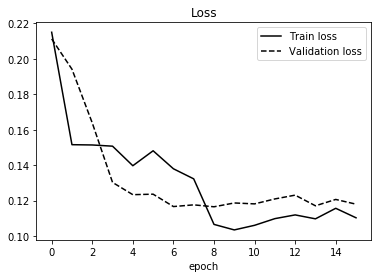

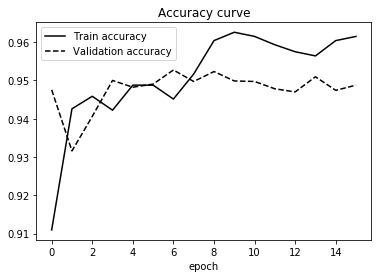

In [16]:
import matplotlib.pyplot as plt

# Loss
plt.plot(subepochs, train_loss, 'k')
plt.plot(subepochs, val_loss, 'k--')
plt.legend(['Train loss', 'Validation loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()
# plt.savefig('../_assets/loss_tcxtc.eps', format='eps', dpi=1000)

# Accuracy
plt.plot(subepochs, train_acc, 'k')
plt.plot(subepochs, val_acc, 'k--')
plt.legend(['Train accuracy', 'Validation accuracy'])
plt.title('Accuracy curve')
plt.xlabel('epoch')
plt.show()
# plt.savefig('../_assets/accuracy_tcxtc.eps', format='eps', dpi=1000)